<a href="https://www.kaggle.com/code/lorresprz/natural-scenes-resnet50-efficientnetv2-vgg16?scriptVersionId=148539006" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Natural Scenes Classification: ResNet50, EfficientNetV2, MobileNetV2, VGG16

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os
from glob import glob
import cv2
import tensorflow as tf

A list of available pretrained models (for image processing applications) can be found here:

https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
from PIL import Image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetV2B2, MobileNetV2
from tensorflow.keras.optimizers import Optimizer, Adam
from tensorflow.keras.utils import load_img
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import plot_model

# Loading images 

Some information about the dataset is included here for clarity:

This dataset contains around 25k images of size 150x150 distributed under 6 categories.

{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.

In [5]:
train_path = '/kaggle/input/intel-image-classification/seg_train/seg_train/'
test_path = '/kaggle/input/intel-image-classification/seg_test/seg_test/'

In [6]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                  zoom_range=0.25,
                                  validation_split=0.2,
                                  width_shift_range=0.15,
                                  height_shift_range=0.15,
                                  horizontal_flip = True,  
                                  vertical_flip = False,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=128,
    subset='training',
    shuffle=True,
    class_mode="categorical",
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=128,
    class_mode="categorical",
    shuffle=False,
    subset="validation"
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=128,
    shuffle=False,
    class_mode="categorical",
)

Found 3000 images belonging to 6 classes.


In [8]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes \n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes 

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


In [9]:
values = list(labels.values())

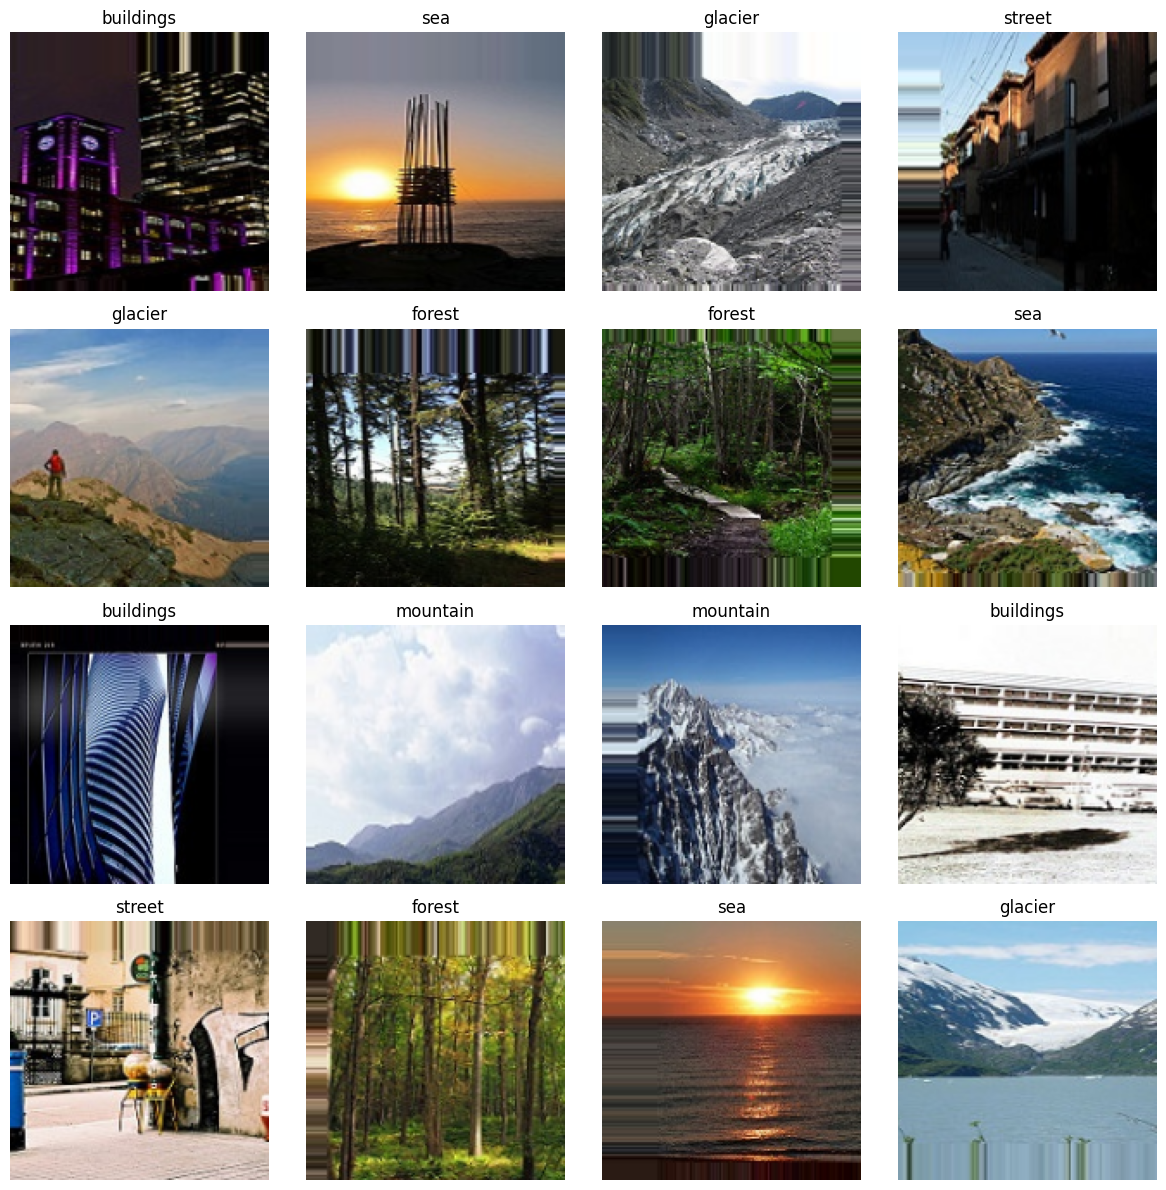

In [10]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
idx = 0

for i in range(4):
    for j in range(4):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

# Define a generic model for later customization

In the following sections, 4 pretrained models were used to classify the images from this dataset. The models are: ResNet50, EfficientNetV2, MobileNetV2, VGG16. The customized top is the same for all 4 models and consists of a GlobalAveragePooling layer, followed by a Dense(128) layer, a Dropout layer (0.2) and a final Dense layer for classification. By using the same customized top, we can compare the performance of the 4 pretrained models later. 

It is useful to define a function that takes in as input the choice of the base model, since the architecture for all models is the same. The output of the function will be the trained model, the accuracy of the trained model evaluated on the test set, and the confusion matrix.

In [11]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.ckpt',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=4,
        restore_best_weights=True
    ),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
]

In [12]:
def pretrained_custom_model(base_model, eps):
    pretrained_base_model = base_model(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

    for layer in pretrained_base_model.layers:
        layer.trainable = False
        
    inputs = Input(shape=(150, 150, 3))
    x = pretrained_base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    x =Dense(6, activation='softmax')(x)
    custom_model = Model(inputs, x)
    custom_model.summary()
    
    #plot_model(custom_model, show_shapes = True)
    
    custom_model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

    history = custom_model.fit(train_generator, validation_data = val_generator,
                                      epochs=eps,callbacks=callbacks)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    #Plot loss and accuracy curves
    fig, ax = plt.subplots(2, 1, figsize = (8, 8))
    epochs = range(1, len(acc) + 1)
    ax[0].plot(epochs, acc, 'b--', label='Training acc')
    ax[0].plot(epochs, val_acc, 'r', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'b--', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    
    #Prediction
    pred = custom_model.predict(test_generator)
    y_test = test_generator.classes
    y_pred = np.argmax(pred, axis=1)
    model_acc = accuracy_score(y_test,y_pred)

    #Confusion matrix
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize = (6,6))
    sns.heatmap(cm,
            annot=True, xticklabels=values,
            yticklabels=values,
            cmap='viridis')
    plt.title('Confusion matrix of the trained model')
    
    print(f'The accuracy of the model is:{model_acc}')
    return custom_model, model_acc, cm

# ResNet50: Pretrained model + customized top

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                             

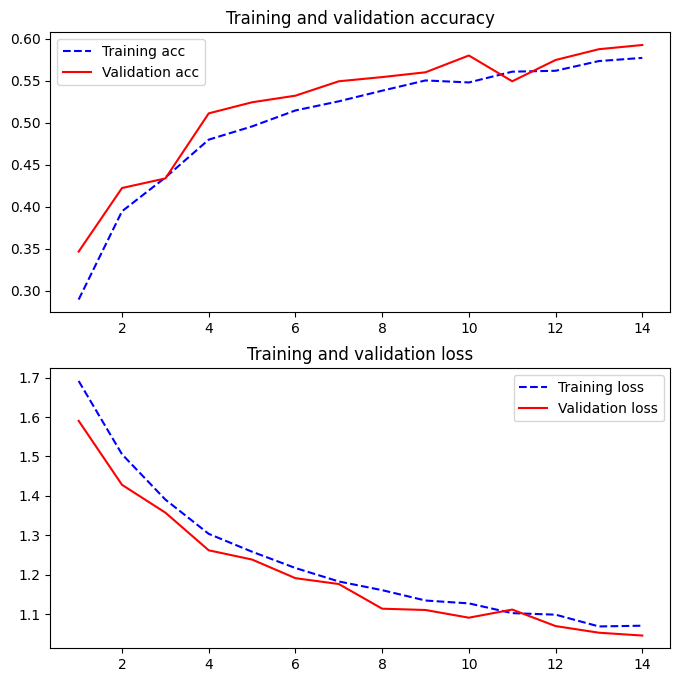

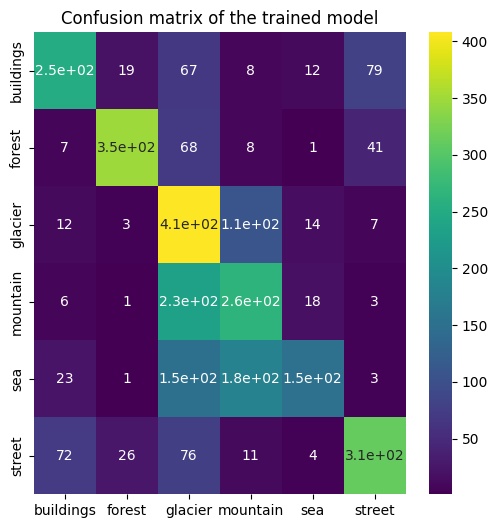

In [13]:
#https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50
resnet50_model = pretrained_custom_model(ResNet50, 15)

# EfficientNetV2: Pretrained model + customized top

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 efficientnetv2-b2 (Function  (None, 5, 5, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               180352    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 774 

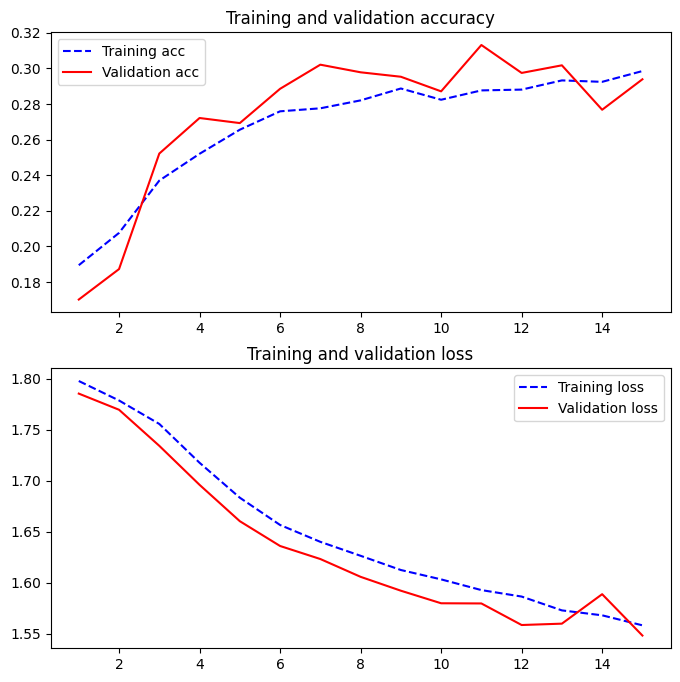

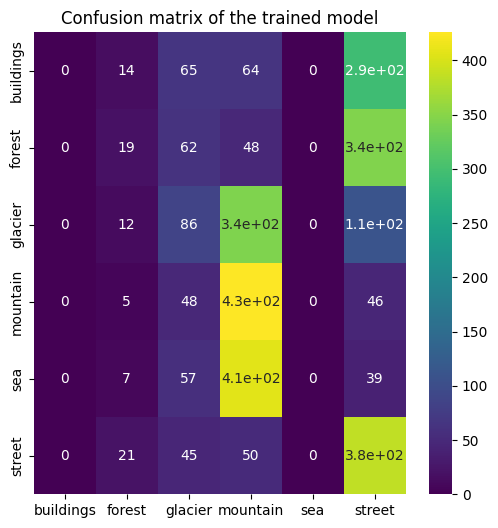

In [14]:
effnet_model = pretrained_custom_model(EfficientNetV2B2, 15)

# MobileNetV2: Pretrained model + customized top

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               163968    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 774 

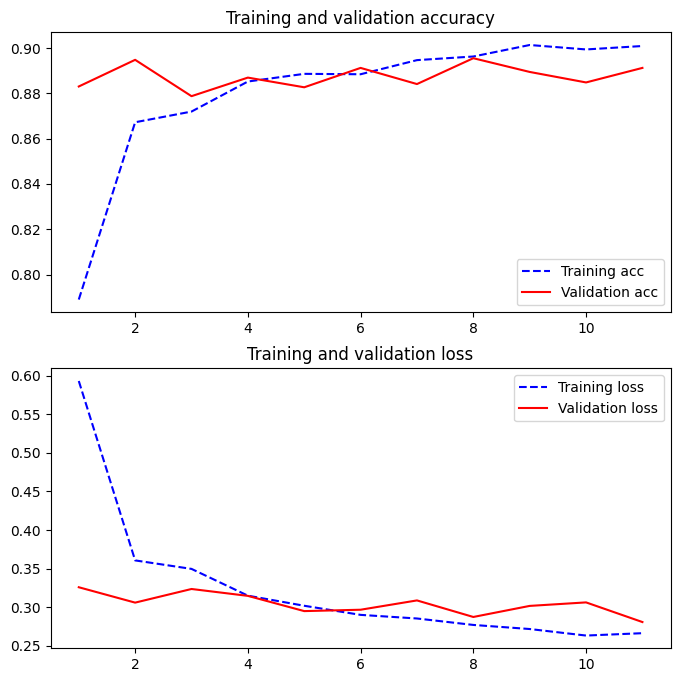

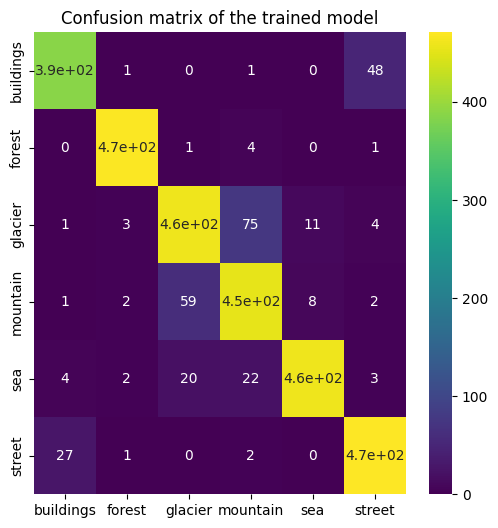

In [15]:
#https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2
mobnet_model = pretrained_custom_model(MobileNetV2, 15)

# VGG16 model: Pretrained model + customized top

58889256/58889256 [==============================] - 2s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 6)                 774  

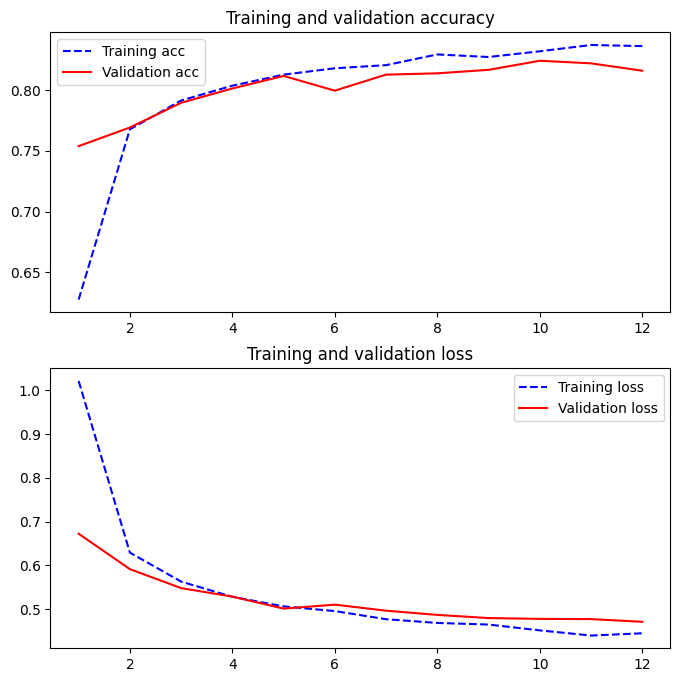

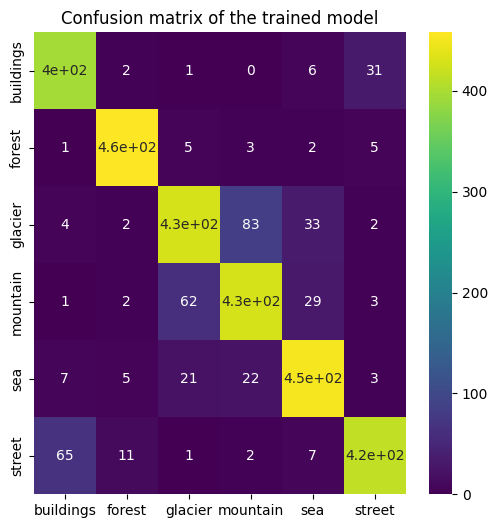

In [16]:
vgg16_model = pretrained_custom_model(VGG16, 15)

# Comparison of accuracy

In [17]:
d  = pd.DataFrame({'Model': ['EfficientNetV2', 'ResNet50','VGG16', 'MobileNetV2'], 
      'Accuracy': [effnet_model[1], resnet50_model[1],  vgg16_model[1],  mobnet_model[1]]})
d = d.set_index('Model')

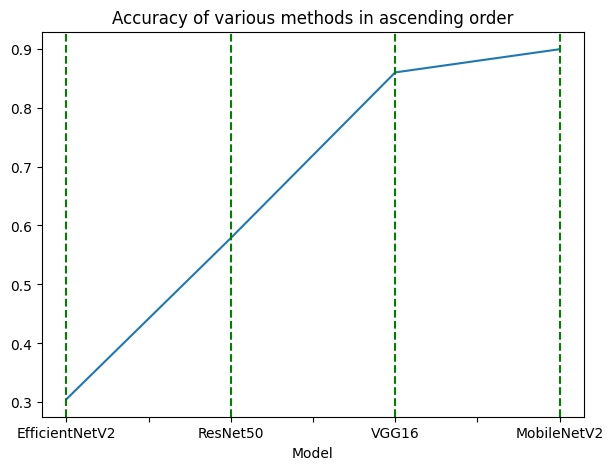

In [18]:
f, ax = plt.subplots(figsize = (7,5))
d['Accuracy'].sort_values(ascending = True).plot(ax = ax)
ax.axvline("EfficientNetV2", color="green", linestyle="dashed")
ax.axvline("ResNet50", color="green", linestyle="dashed")
ax.axvline("VGG16", color="green", linestyle="dashed")
ax.axvline("MobileNetV2", color="green", linestyle="dashed")
plt.title('Accuracy of various methods in ascending order');